# Acoustic modelling with Devito

This notebook showcases how to perform 2D acoustic modelling Devito.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import segyio
import numpy as np
import matplotlib.pyplot as plt
import devito

from scipy.interpolate import RegularGridInterpolator
from examples.seismic import Model, RickerSource

from devitomod.acoustic.ac2d import Acoustic2D

devito.configuration['log-level'] = 'ERROR'

## Velocity model

In [2]:
# Load model
f = np.load('../data/SeamPhase1.npz')

vp = f['vp']
x, z = f['x'], f['z']
nx, nz = len(x), len(z)
dx, dz = x[1] - x[0], z[1] - z[0]

## Modelling parameters

In [3]:
# velocity model parameter
shape = (nx, nz)
spacing = (dx, dz)
origin = (0, 0)

# source and receiver geometry
nsrc = 3
nrec = nx
osrc = x[-1]//4

# other modelling params
nbl = 150 # Number of boundary layers around the domain
space_order = 6 # Space order of the simulation
f0 = 10 # Source peak frequency (Hz)
fs = True
fslabel = '_fs' if fs else ''

t0 = 0. # Initial time
tmax = 30000 # Total simulation time (ms)
dt = 4 # Time sampling of observed data (ms)

## Modelling

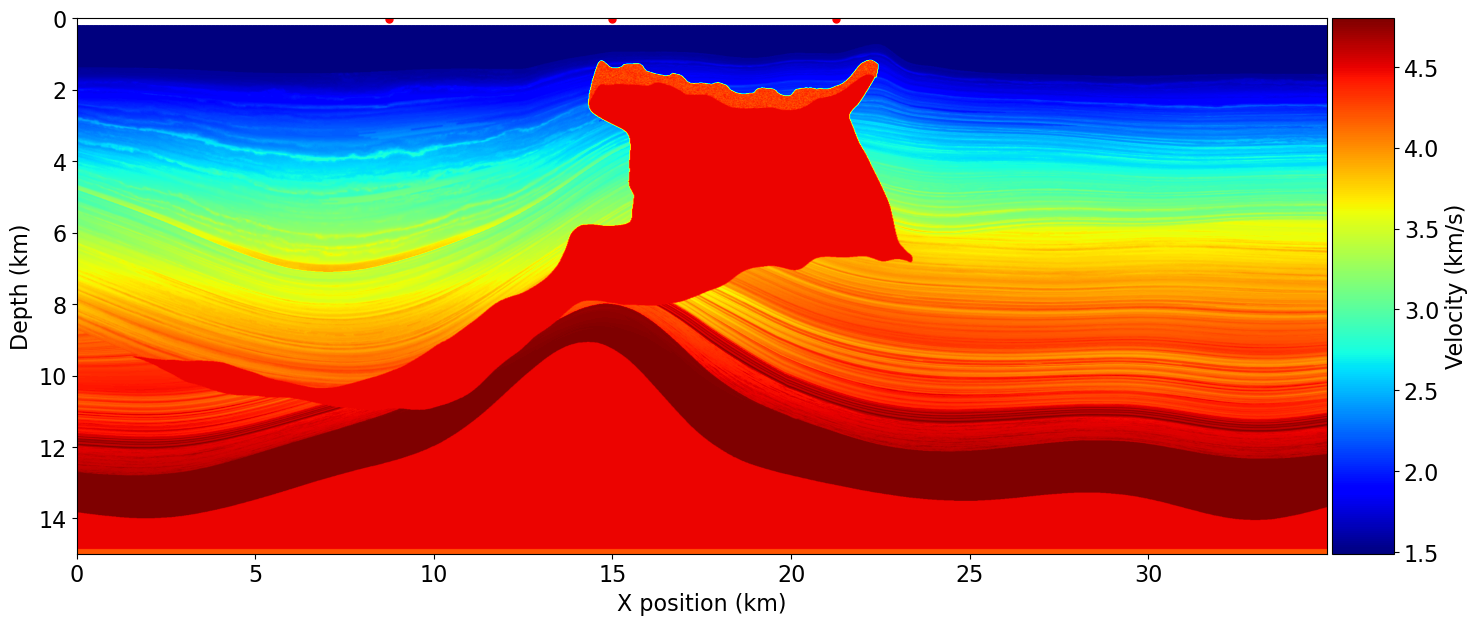

In [4]:
awe = Acoustic2D()

awe.create_model(shape, origin, spacing, vp.T, space_order, nbl=nbl, fs=fs)
awe.create_geometry(src_x=np.arange(0, nsrc) * spacing[0] * 500 + osrc,
                    src_z=20,
                    rec_x=np.arange(0, nrec) * spacing[0],
                    rec_z=20,
                    t0=t0, tn=tmax, src_type='Ricker', f0=f0)

awe.plot_velocity(figsize=(17, 9))

### Model single shot

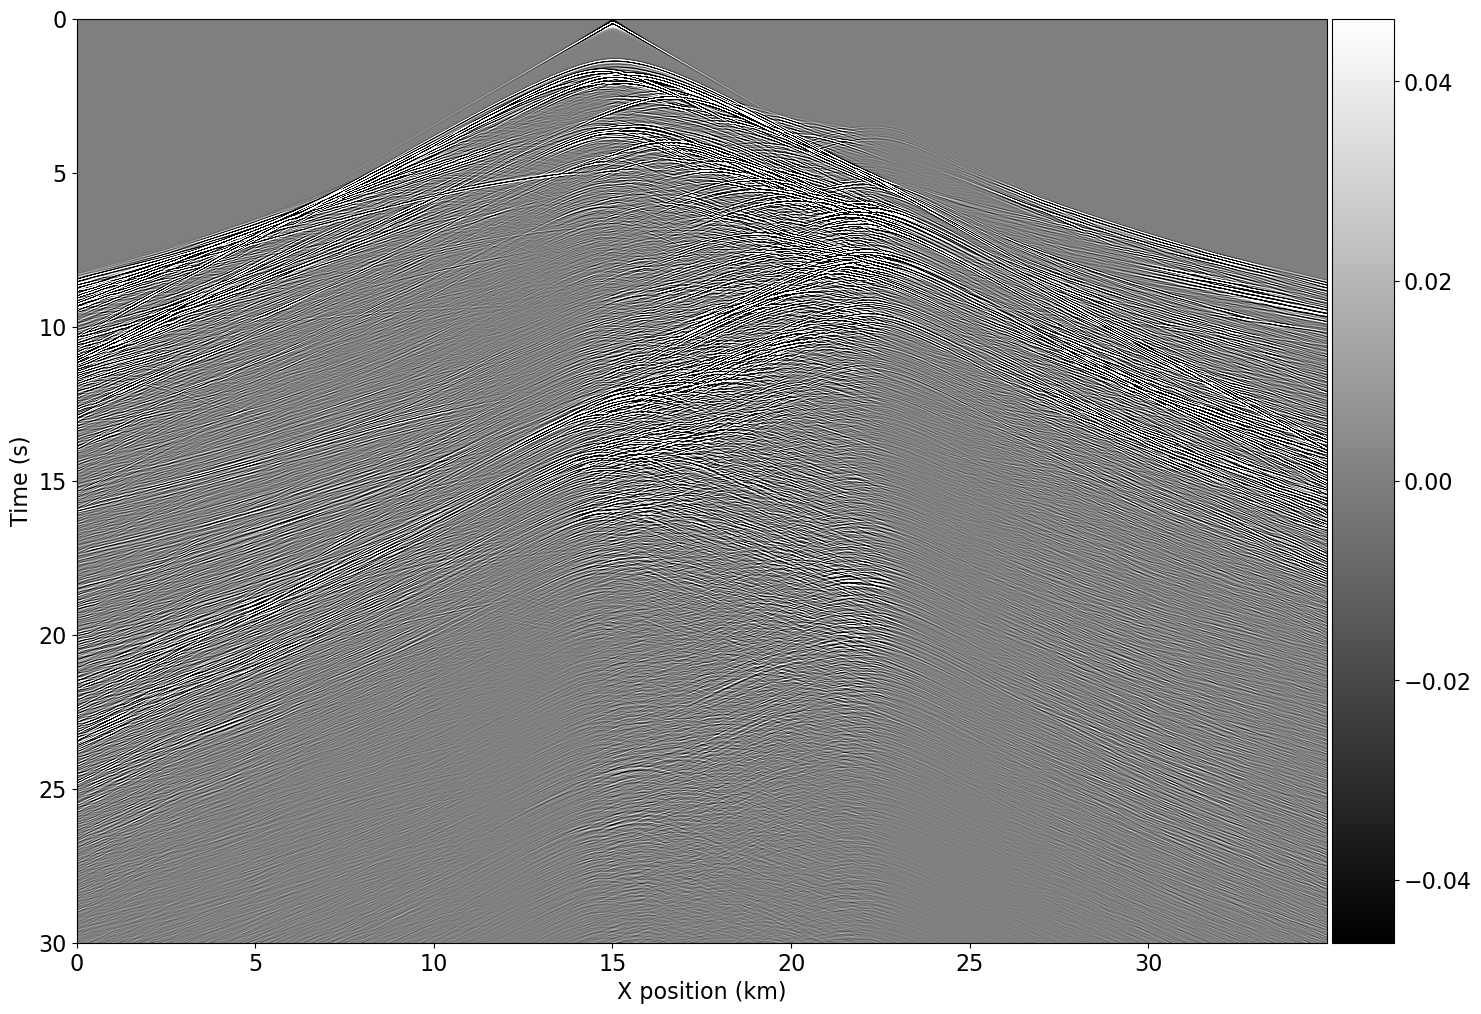

In [5]:
isrc = nsrc//2
d, _, _ = awe.solve_one_shot(isrc)

ax = awe.plot_shotrecord(d.data, clip=1e-3)

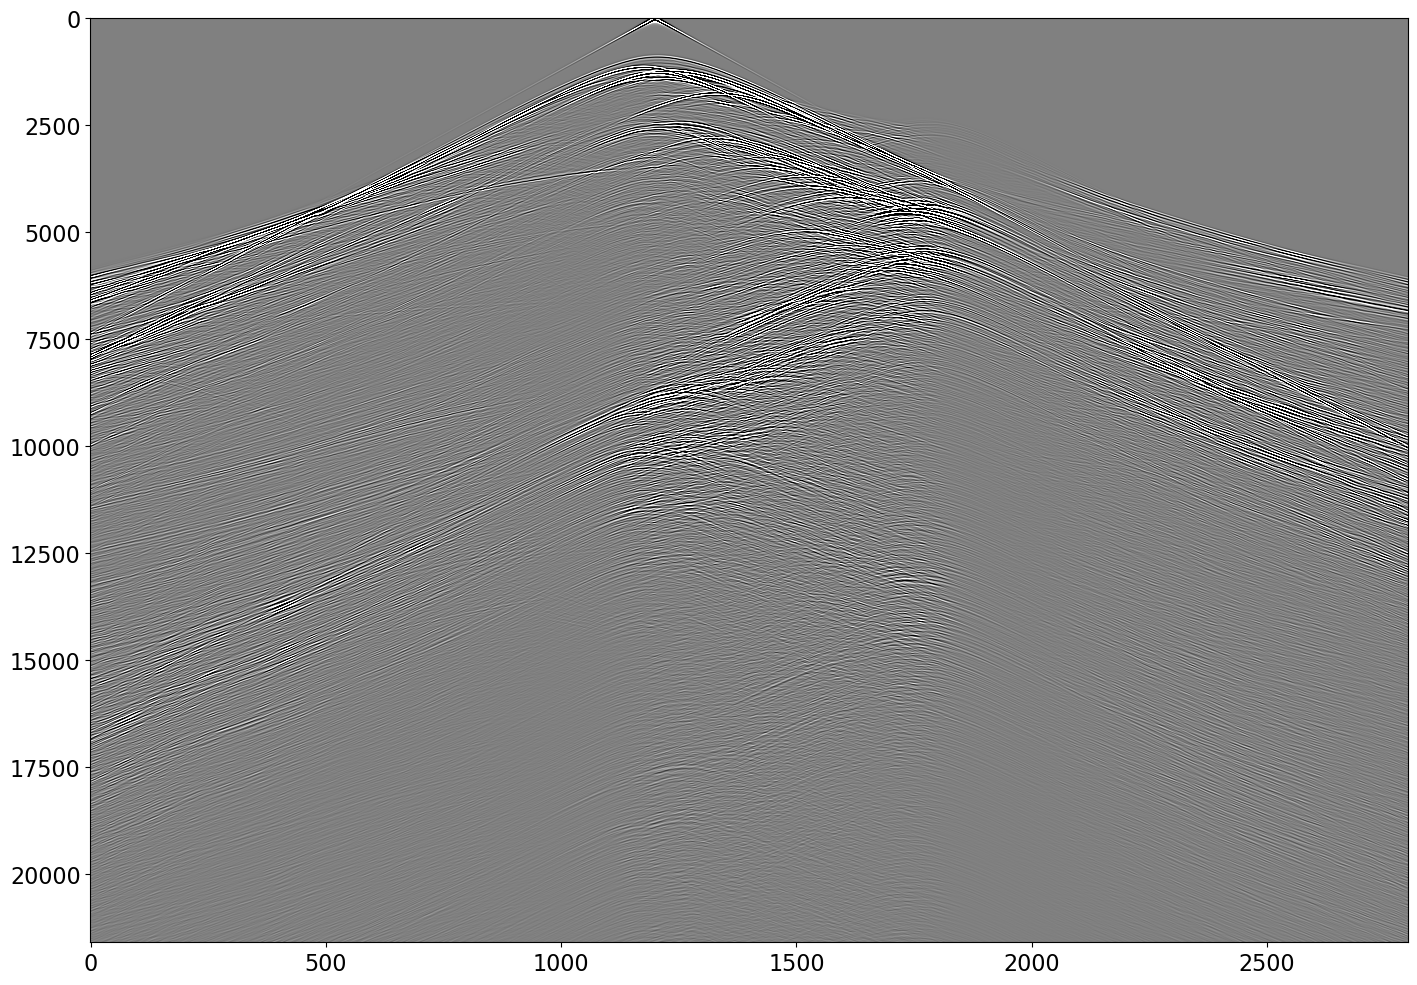

In [6]:
# Cutting data to wavelet center and visualize
wav = awe.geometry.src.data[:, 0]
wavc = np.argmax(wav)

plt.figure(figsize=(17, 12))
plt.imshow(d.data[wavc:], cmap='gray', vmin=-1e-1, vmax=1e-1)
plt.axis('tight');

### Model multiple shots

In [7]:
dtot, taxis = awe.solve_all_shots(dt=dt, savedtot=True)
                                  #figdir=f'figs{fslabel}_open', 
                                  #savedtot=False, datadir=f'shots{fslabel}_open', )

100%|██████████| 3/3 [07:12<00:00, 144.27s/it]


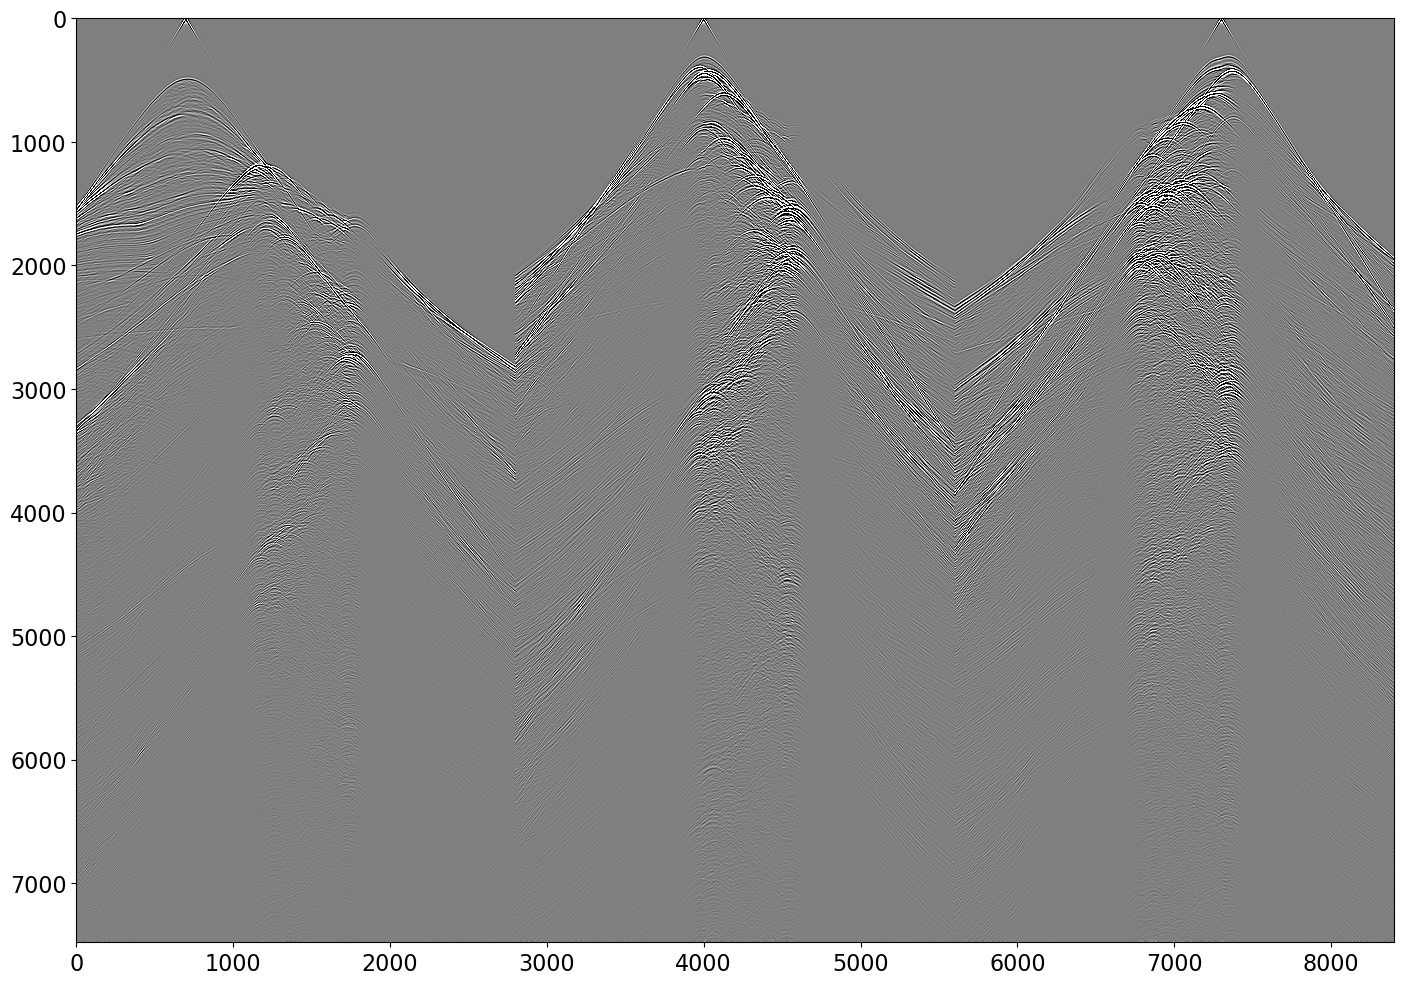

In [25]:
# Cutting data to wavelet center and visualize
wav = awe.geometry.src.resample(dt).data[:, 0]
wavc = np.argmax(wav)

plt.figure(figsize=(17, 12))
plt.imshow(dtot.reshape(nrec*nsrc, -1)[:, wavc:].T, cmap='gray', vmin=-1e-1, vmax=1e-1)
plt.axis('tight');